순서 정리
1. 이미지 불러오기
2. 모델 불러오기
3. 세그멘테이션 따기
4. 인물, 배경만 남기기
5. 블러 처리하기
6. 블러 처리한 곳에서 인물만 검은색으로 바꾸기
7. 합성하기

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

from importlib.metadata import version
import cv2
import pixellib


Matplotlib is building the font cache; this may take a moment.


In [2]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


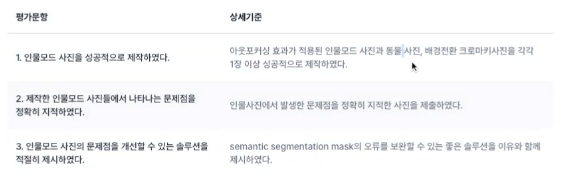

# 1. 인물모드 직접해보기

## 모델 불러오기

In [3]:
# # 모델 불러오기
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# # PixelLib가 제공하는 모델의 url입니다
# model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# # 다운로드를 시작합니다
# urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

In [4]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [5]:
os.listdir('./')

['Study.ipynb', '.ipynb_checkpoints', '좌측셀카.jpg', '강아지.jpg', 'Project.ipynb']

## 이미지 불러오기

(1472, 1104, 3)


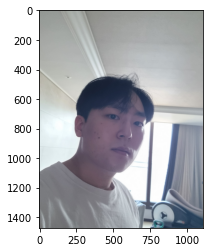

In [28]:
# 이미지 불러오기
img_path = './좌측셀카.jpg' 
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## Segmentation 

In [8]:
# segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 
# 분할 은 pacalvoc 데이터로 학습된 모델을 이용
segvalues, output = model.segmentAsPascalvoc(img_path) 

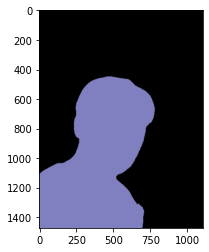

In [9]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [10]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [11]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [13]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

In [15]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)
seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

(1472, 1104)


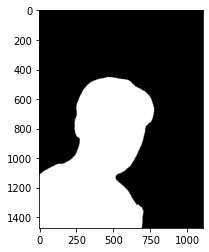

In [16]:
# segmentation map 만들기
# seg color와 같으면 True, 다르면 False로 출력됨
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

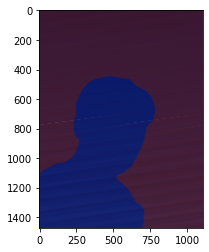

In [36]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 블러 처리하기

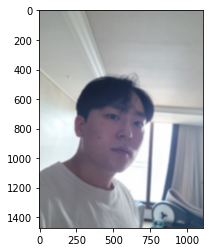

In [19]:
img_orig_blur = cv2.blur(img_orig, (13,13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 블러 처리된 이미지에서 사람 없애기

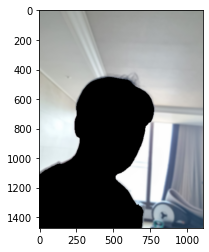

In [21]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# 이미지 반전하기
# 배경이 0, 사람이 255 -> 배경이 255, 사람이 0
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 사진 합성하기

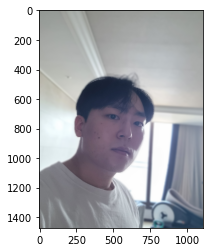

In [25]:
# 0은 검은색, 255는 흰색
# 0이 아닌, 색이 있는 부분에 원래 이미지를 채워넣는다. 
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 2. 배경을 다른 걸로 바꿔보기

## 배경 불러오기

(1472, 1104, 3)


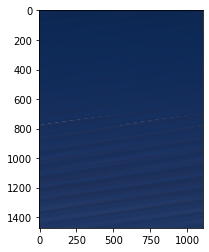

In [31]:
# 이미지 불러오기
bg_img_path = './배경.jpg' 
bg_img_orig = cv2.imread(bg_img_path) 

# 셀카랑 같은 사이즈로 바꾸기
bg_img_orig.resize((1472, 1104, 3))

print(bg_img_orig.shape)
plt.imshow(cv2.cvtColor(bg_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 셀카에서 배경 지우기

(1472, 1104)


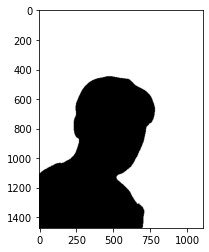

In [34]:
# segmentation map 만들기
# seg color와 같으면 True, 다르면 False로 출력됨
seg_map = np.all(output==(0, 0, 0), axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

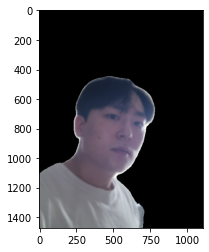

In [37]:
# img_mask는 seg_map을 0또는 255값으로 바꾼 것.
img_mask = seg_map.astype(np.uint8) * 255

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# 이미지 반전하기
# 배경이 0, 사람이 255 -> 배경이 255, 사람이 0
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용해서 사람만 얻기
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 배경 합성하기

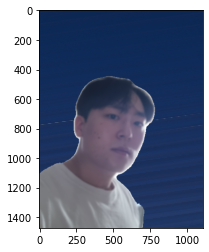

In [39]:
# 0은 검은색, 255는 흰색
# 0이 아닌, 색이 있는 부분에 원래 이미지를 채워넣는다. 
img_concat = np.where(img_mask_color==255, bg_img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 강아지 사진에 적용하기

## 이미지 불러오기

(525, 700, 3)


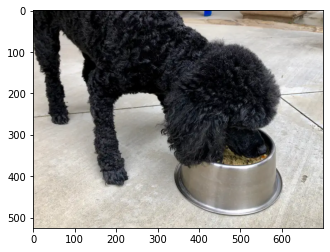

In [70]:
# 이미지 강아지
img_path = './강아지.jpg' 
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## Segmentation 따기

In [71]:
# Segmentation 적용
# segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 
# 분할 은 pacalvoc 데이터로 학습된 모델을 이용
segvalues, output = model.segmentAsPascalvoc(img_path) 

In [72]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [73]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

In [74]:
print(colormap[12]) #컬러맵 12에 해당하는 값 -> 강아지
seg_color = (128, 0, 64) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

[ 64   0 128]


## seg map 만들기

(525, 700)


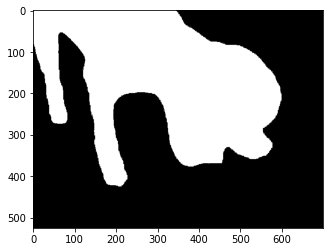

In [75]:
# segmentation map 만들기
# seg color와 같으면 True, 다르면 False로 출력됨
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

## 블러 처리하기

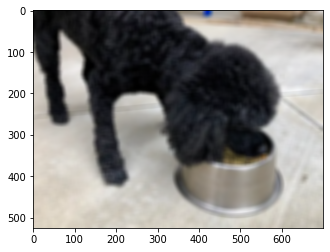

In [76]:
# 블러 처리하기
img_orig_blur = cv2.blur(img_orig, (13,13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 블러 처리한 이미지에 강아지만 없애고 합성하기

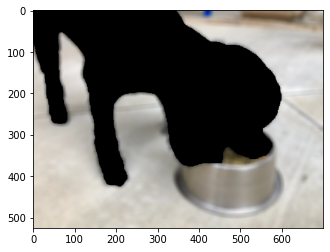

In [77]:
# img_mask는 seg_map을 0또는 255값으로 바꾼 것.
img_mask = seg_map.astype(np.uint8) * 255

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# 이미지 반전하기
# 배경이 0, 사람이 255 -> 배경이 255, 사람이 0
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

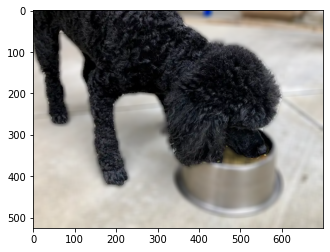

In [80]:
# 0은 검은색, 255는 흰색
# 0이 아닌, 색이 있는 부분에 원래 이미지를 채워넣는다. 
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 문제점

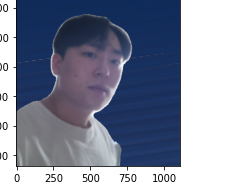    
위 사진에서 왼쪽 어깨 밑에 쇼파가 같이 묶여서 segmentation 됨   
-> 어캐 해결하누?? 고민해보자

# 해결책 고민해보기




- 모델 관점   
    - 사용하고 있는 pretrained model을 더 학습시켜볼 수 있을 것 같습니다.   
    ( 더욱 더 정확하게 세그멘테이션을 진행할 수 있도록 기대해볼 수 있습니다. )
    - 뿐만 아니라 유명한 다른 모델들과 앙상블해서 성능 향상을 기대할 수 있을 것 같습니다.   
- 데이터 관점   
    - 사진의 밝기를 조정한다거나 대조하는 등, 다양한 변주를 주면서 모델을 학습시켜볼 수 있을 것 같고,    
    - 애초에 사진을 찍을 때 배경과 옷의 차이를 명확히 주는게 좋을 것 같다.(크로마키)   



# 회고

Segmentation이 정확히 어떻게 진행되는지 모르니까 좀 답답했다.   
모델이 어떻게 생겼는지는 알겠지만(?) 구체적으로 어떻게 되는지를 알아야 문제점과 해결책을 생각해볼 수 있을 것 같다.   
  
사전 학습된 모델을 불러오는 정도였지만, 꽤 신기했고 컴퓨터가 이미지를 인식하는, 사진을 볼 수 있다는 개념 자체가 꽤나 흥미롭게 다가온다.